## 以Inception模型为例，通过图文件导入模型

### 11.1导入Inception模型

### 导入库

In [4]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
import scipy.misc
import tensorflow as tf
import matplotlib

### 创建图和会话

In [5]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph = graph)

D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 导入模型
Tensorflow提供了一种以'.pb'为扩展名的文件，可以事先将模型导入到pb文件中，再在需要的时候导出

In [6]:
model_fn = 'tensorflow_inception_graph.pb' # 导入Inception网络
# tensorflow_inception_graph.pb文件的下载：
# https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip

with tf.gfile.GFile(model_fn,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [7]:
# 定义输入图像的占位符
t_input = tf.placeholder(np.float32, name='input')

# 图像预处理——减均值
imagenet_mean = 117.0 # 在训练Inception模型时做了减均值预处理，此处也需减同样的均值以保持一致

# 图像预处理——增加维度
# 图像数据格式一般是（height, width, channels）,为同时将多张图片输入网络而在前面增加一维变为（batch,height,width,channel）
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)

# 导入模型并将经预处理的图像送入网络
tf.import_graph_def(graph_def, {'input':t_preprocessed})

### 找出卷积层或可视化的卷积层

In [8]:
layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D']
# 输出卷积层层数
print('Number of layers', len(layers))

Number of layers 59


In [9]:
# 输出所有卷积层名称
print(layers)

['import/conv2d0_pre_relu/conv', 'import/conv2d1_pre_relu/conv', 'import/conv2d2_pre_relu/conv', 'import/mixed3a_1x1_pre_relu/conv', 'import/mixed3a_3x3_bottleneck_pre_relu/conv', 'import/mixed3a_3x3_pre_relu/conv', 'import/mixed3a_5x5_bottleneck_pre_relu/conv', 'import/mixed3a_5x5_pre_relu/conv', 'import/mixed3a_pool_reduce_pre_relu/conv', 'import/mixed3b_1x1_pre_relu/conv', 'import/mixed3b_3x3_bottleneck_pre_relu/conv', 'import/mixed3b_3x3_pre_relu/conv', 'import/mixed3b_5x5_bottleneck_pre_relu/conv', 'import/mixed3b_5x5_pre_relu/conv', 'import/mixed3b_pool_reduce_pre_relu/conv', 'import/mixed4a_1x1_pre_relu/conv', 'import/mixed4a_3x3_bottleneck_pre_relu/conv', 'import/mixed4a_3x3_pre_relu/conv', 'import/mixed4a_5x5_bottleneck_pre_relu/conv', 'import/mixed4a_5x5_pre_relu/conv', 'import/mixed4a_pool_reduce_pre_relu/conv', 'import/mixed4b_1x1_pre_relu/conv', 'import/mixed4b_3x3_bottleneck_pre_relu/conv', 'import/mixed4b_3x3_pre_relu/conv', 'import/mixed4b_5x5_bottleneck_pre_relu/conv',

In [10]:
# 输出指定卷积层的参数
name1 = 'mixed4d_3x3_bottleneck_pre_relu'
print('shape of %s:%s' % (name1, str(graph.get_tensor_by_name('import/'+name1+':0').get_shape())))

name2 = 'mixed4e_5x5_bottleneck_pre_relu'
print('shape of %s:%s' % (name2, str(graph.get_tensor_by_name('import/'+name2+':0').get_shape())))

shape of mixed4d_3x3_bottleneck_pre_relu:(?, ?, ?, 144)
shape of mixed4e_5x5_bottleneck_pre_relu:(?, ?, ?, 32)


卷积层格式一般是（batch, height, width, channel），因为此时还不清楚输入图像的数量及大小，所以前三个维度是不确定的，显示“？”。由于导入的是已训练好的模型，所以指定的卷积层的通道数量是固定的

## 11.2生成原始的Deep Dream图像

### 定义相关函数

In [11]:
from PIL import Image

# 把一个numpy.ndarray保存成图像文件
def savearray(img_array, img_name):
    scipy.misc.toimage(img_array).save(img_name)
    # 报错：module 'scipy.misc' has no attribute 'toimage',scipy在1.2.0版本后折旧，需要安装1.1.0版本
    print('img saved:%s' % img_name)
    
    
# 渲染函数
def render_naive(t_obj, img0, iter_n=20, step=1.0):
    # t_obj:是layer_output[:,:,:,channel],即卷积层某个通道的值
    # img0:初始图像（噪声图像）
    # iter_n：迭代次数
    # step：用于控制每次迭代步长，可以看作学习率
    t_score = tf.reduce_mean(t_obj)
    # t_score是t_obj的平均值
    # 由于我们的目标是调整输入图像使卷积层激活值尽可能大
    # 即最大化t_score
    # 为达到此目标，可使用梯度下降
    # 计算t_score对t_input的梯度
    t_grad = tf.gradients(t_score, t_input)[0]
    
    img = img0.copy() # 赋值新图像可避免影响原图像的值
    for i in range(iter_n):
        # 在sess中计算梯度，以及当前的t_score
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # 对img应用梯度
        # 首先对梯度进行归一化处理
        g /= g.std() + 1e-8
        # 将正规化处理后的梯度应用在图像上，step用于控制每次迭代步长，此处为1.0
        img += g * step
        print('iter:%d' %(i+1), 'score(mean)=%f'%score)
    # 保存图片
    savearray(img, 'naive_deepdream.jpg')
    # matplotlib.image.imsave('naive_deepdream.jpg', img)
    #print(img.shape)
    #im = Image.fromarray(np.trunc(img))
    #im.save('naive_deepdream.jpg')

### 11.2.1 通过单通道特征生成DeepDream图像


iter:1 score(mean)=-19.798367
iter:2 score(mean)=-35.710022
iter:3 score(mean)=8.153250
iter:4 score(mean)=82.666779
iter:5 score(mean)=143.085892
iter:6 score(mean)=214.070053
iter:7 score(mean)=280.248016
iter:8 score(mean)=325.196655
iter:9 score(mean)=368.348175
iter:10 score(mean)=410.855072
iter:11 score(mean)=455.158478
iter:12 score(mean)=503.173004
iter:13 score(mean)=540.171326
iter:14 score(mean)=577.526917
iter:15 score(mean)=601.818237
iter:16 score(mean)=638.839355
iter:17 score(mean)=655.872253
iter:18 score(mean)=684.756775
iter:19 score(mean)=707.943481
iter:20 score(mean)=726.599182
img saved:naive_deepdream.jpg


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


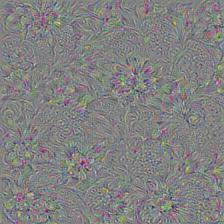

In [14]:
# 定义卷积层、通道数，并取出对应的tensor
name = 'mixed4d_3x3_bottleneck_pre_relu' #(?,?,?,144)
channel = 139
# 'mixed4d_3x3_bottleneck_pre_relu'共144个通道
# 这里选任意通道（0~143之间任意整数）进行最大化

layer_output = graph.get_tensor_by_name('import/%s:0' % name)
# layer_output[:,:,:,channel]即可表示该卷积层的第140个通道

# 定义图像噪声
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

# 调用render_naive函数渲染
render_naive(layer_output[:,:,:,channel], img_noise, iter_n=20)

#保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('naive_single_chn.jpg')

from IPython.display import Image as IMG
display(IMG('naive_single_chn.jpg'))

### 11.2.2 利用较低层单通道卷积特征生成deepdream图像

In [15]:
# 定义卷积层、通道数，并取出对应的tensor
name3 = 'mixed3a_3x3_bottleneck_pre_relu'
layer_output = graph.get_tensor_by_name('import/%s:0' % name3)
print('shape of %s:%s' % (name3, str(graph.get_tensor_by_name('import/'+name3+':0').get_shape())))

shape of mixed3a_3x3_bottleneck_pre_relu:(?, ?, ?, 96)


iter:1 score(mean)=5.905701
iter:2 score(mean)=47.427666
iter:3 score(mean)=133.956848
iter:4 score(mean)=202.477783
iter:5 score(mean)=246.048187
iter:6 score(mean)=276.934662
iter:7 score(mean)=299.297699
iter:8 score(mean)=315.213715
iter:9 score(mean)=328.367462
iter:10 score(mean)=338.910553
iter:11 score(mean)=347.947021
iter:12 score(mean)=354.993774
iter:13 score(mean)=361.614227
iter:14 score(mean)=367.173553
iter:15 score(mean)=372.205109
iter:16 score(mean)=376.695404
iter:17 score(mean)=380.577576
iter:18 score(mean)=384.235718
iter:19 score(mean)=387.065643
iter:20 score(mean)=390.394379
img saved:naive_deepdream.jpg


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


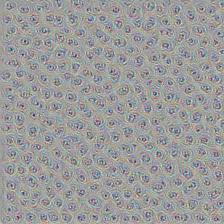

In [17]:
# 定义噪声图像
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

# 调用render_naive函数渲染
channel = 86
render_naive(layer_output[:,:,:,channel], img_noise, iter_n=20)

# 保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('shallow_single_chn.jpg')
display(IMG('shallow_single_chn.jpg'))

### 11.2.3 利用较高层单通道卷积特征生成deepdream图像


In [18]:
# 定义卷积层、通道数，并取出对应的tensor
name4 = 'mixed5b_5x5_pre_relu'
layer_output = graph.get_tensor_by_name('import/%s:0' % name4)
print('shape of %s:%s' % (name4, str(graph.get_tensor_by_name('import/'+name4+':0').get_shape())))

shape of mixed5b_5x5_pre_relu:(?, ?, ?, 128)


iter:1 score(mean)=-7.710807
iter:2 score(mean)=-7.244145
iter:3 score(mean)=-2.856252
iter:4 score(mean)=7.579222
iter:5 score(mean)=19.096811
iter:6 score(mean)=31.615845
iter:7 score(mean)=39.712975
iter:8 score(mean)=50.174149
iter:9 score(mean)=49.005341
iter:10 score(mean)=62.507149
iter:11 score(mean)=69.010162
iter:12 score(mean)=70.818558
iter:13 score(mean)=86.392502
iter:14 score(mean)=90.256676
iter:15 score(mean)=102.658409
iter:16 score(mean)=110.692223
iter:17 score(mean)=120.718254
iter:18 score(mean)=122.841011
iter:19 score(mean)=138.417343
iter:20 score(mean)=148.054016
img saved:naive_deepdream.jpg


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


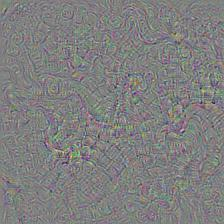

In [19]:
# 定义噪声图像
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

# 调用render_naive函数渲染
channel = 118
render_naive(layer_output[:,:,:,channel], img_noise, iter_n=20)

# 保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('deep_single_chn.jpg')
display(IMG('deep_single_chn.jpg'))

### 11.2.4利用多通道卷积生成deepdream图像

shape of mixed4d_3x3_bottleneck_pre_relu:(?, ?, ?, 144)
shape of mixed4e_5x5_bottleneck_pre_relu:(?, ?, ?, 32)
iter:1 score(mean)=-7.228029
iter:2 score(mean)=-10.244915
iter:3 score(mean)=-6.839198
iter:4 score(mean)=-1.498458
iter:5 score(mean)=2.507338
iter:6 score(mean)=8.372593
iter:7 score(mean)=12.650838
iter:8 score(mean)=15.630845
iter:9 score(mean)=21.411060
iter:10 score(mean)=24.589880
iter:11 score(mean)=28.994926
iter:12 score(mean)=33.292965
iter:13 score(mean)=35.668636
iter:14 score(mean)=39.165283
iter:15 score(mean)=41.923916
iter:16 score(mean)=44.103489
iter:17 score(mean)=46.295277
iter:18 score(mean)=48.388313
iter:19 score(mean)=50.323330
iter:20 score(mean)=53.297768
img saved:naive_deepdream.jpg


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


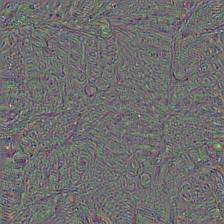

In [21]:
# 定义卷积层，并取出对应的tensor
name1 = 'mixed4d_3x3_bottleneck_pre_relu' #(?,?,?,144)
#name2 = 'mixed4e_5x5_bottleneck_pre_relu' #(?,?,?,32)
channel1 = 139
channel2 = 28

layer_output1 = graph.get_tensor_by_name('import/%s:0' % name1)
#layer_output2 = graph.get_tensor_by_name('import/%s:0' % name2)
print('shape of %s:%s' % (name1, str(graph.get_tensor_by_name('import/'+name1+':0').get_shape())))
#print('shape of %s:%s' % (name2, str(graph.get_tensor_by_name('import/'+name2+':0').get_shape())))

# 定义图像噪声
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

# 调用render_naive函数渲染
render_naive(layer_output1[:,:,:,channel2:channel1], img_noise, iter_n=20)

#保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('mutil_chn.jpg')
display(IMG('mutil_chn.jpg'))

### 11.2.5 利用所有通道特征生成deepdream图像

iter:1 score(mean)=-6.699615
iter:2 score(mean)=-9.767220
iter:3 score(mean)=-5.107193
iter:4 score(mean)=1.415971
iter:5 score(mean)=5.764118
iter:6 score(mean)=12.823659
iter:7 score(mean)=16.015194
iter:8 score(mean)=20.649412
iter:9 score(mean)=23.634245
iter:10 score(mean)=27.626156
iter:11 score(mean)=29.665615
iter:12 score(mean)=32.242970
iter:13 score(mean)=36.391243
iter:14 score(mean)=39.654411
iter:15 score(mean)=41.437847
iter:16 score(mean)=42.686951
iter:17 score(mean)=45.360924
iter:18 score(mean)=47.440720
iter:19 score(mean)=50.829891
iter:20 score(mean)=51.958233
img saved:naive_deepdream.jpg


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


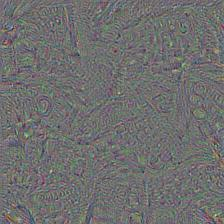

In [22]:
# 定义卷积层，并取出对应的tensor
name = 'mixed4d_3x3_bottleneck_pre_relu' #(?,?,?,144)
layer_output = graph.get_tensor_by_name('import/%s:0' % name)

# 定义图像噪声
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

# 调用render_naive函数渲染
render_naive(layer_output, img_noise, iter_n=20)# 不指定特定通道，即表示利用所有通道特征

#保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('all_chn.jpg')
display(IMG('all_chn.jpg'))

### 11.2.6 利用背景图像生成deepdream图像

In [23]:
# 定义卷积层，并取出对应的tensor
name = 'mixed4c'
layer_output = graph.get_tensor_by_name('import/%s:0' % name)
print(layer_output)

Tensor("import/mixed4c:0", shape=(?, ?, ?, 512), dtype=float32, device=/device:CPU:0)


iter:1 score(mean)=13.039110
iter:2 score(mean)=19.383553
iter:3 score(mean)=26.859833
iter:4 score(mean)=33.929298
iter:5 score(mean)=39.912254
iter:6 score(mean)=45.326698
iter:7 score(mean)=50.238174
iter:8 score(mean)=54.467319
iter:9 score(mean)=58.327110
iter:10 score(mean)=61.892525
iter:11 score(mean)=65.174721
iter:12 score(mean)=68.301033
iter:13 score(mean)=70.989845
iter:14 score(mean)=73.654099
iter:15 score(mean)=76.258476
iter:16 score(mean)=78.235771
iter:17 score(mean)=80.552315
iter:18 score(mean)=82.473038
iter:19 score(mean)=84.483421
iter:20 score(mean)=86.126228
iter:21 score(mean)=88.032104
iter:22 score(mean)=89.406013
iter:23 score(mean)=91.234085
iter:24 score(mean)=92.354622
iter:25 score(mean)=94.129951
iter:26 score(mean)=95.184944
iter:27 score(mean)=96.522499
iter:28 score(mean)=97.695389
iter:29 score(mean)=99.086929
iter:30 score(mean)=99.939522
iter:31 score(mean)=101.224350
iter:32 score(mean)=102.264259
iter:33 score(mean)=103.276382
iter:34 score(me

D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


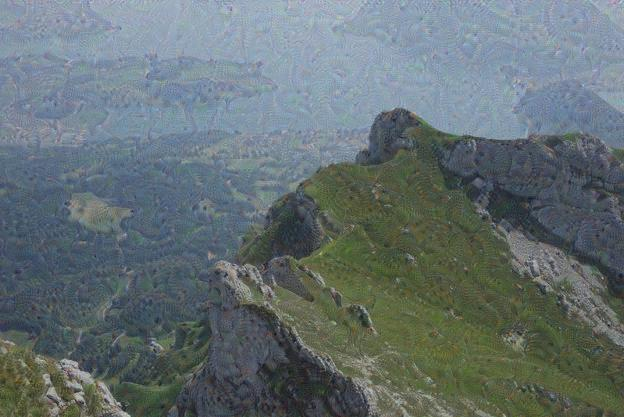

In [24]:
# 用一张背景图像（而不是随机噪声图像）作为起点对图像进行优化
img_test = PIL.Image.open('mountain.jpg')

# 调用render_naive函数渲染
render_naive(layer_output, img_test, iter_n=100)# 不指定特定通道，即表示利用所有通道特征

#保存并显示图片
im = PIL.Image.open('naive_deepdream.jpg')
im.show()
im.save('mountain_naive.jpg')
display(IMG('mountain_naive.jpg'))

## 生成更高质量的Deep Dream图像

### 导入库与Inception模型

In [25]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
import scipy.misc
import tensorflow as tf

graph = tf.Graph()
model_fn = 'tensorflow_inception_graph.pb'
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.GFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})


D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 定义相关函数

In [26]:
# 保存图像
def savearray(img_array, img_name):
    scipy.misc.toimage(img_array).save(img_name)
    print('img saved:%s'% img_name)
    
# 将图像放大ratio倍
def resize_ratio(img, ratio):
    min = img.min()
    max = img.max()
    img = (img-min) / (max - min) * 255
    img = np.float32(scipy.misc.imresize(img, ratio))
    img = img / 255*(max-min) + min
    return img

# 调整图像尺寸
def resize(img, hw):
    min = img.min()
    max = img.max()
    img = (img-min) / (max - min) * 255
    img = np.float32(scipy.misc.imresize(img, hw))
    img = img / 255*(max-min) + min
    return img

# 原始图像尺寸可能很大，从而导致内存耗尽问题
# 每次只对tile_size * tile_size大小的图像计算梯度，避免内存问题
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx,1), sy, 0)# 先在行上做整体移动，再在列上做整体移动
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz//2, sz), sz):
        for x in range(0, max(w - sz//2, sz), sz):
            sub = img_shift[y:y+sz, x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)
    

# 渲染函数,对图像进行拉普拉斯分解
def render_deepdream(t_obj, img0, 
                     iter_n=20, step=1.5, octave_n=4, octave_scale=1.4):
    # t_obj:是layer_output[:,:,:,channel],即卷积层某个通道的值
    # img0:初始图像（噪声图像）
    # iter_n：迭代次数
    # step：用于控制每次迭代步长，可以看作学习率
    # octave_n：金字塔层数
    # octave_scale：层与层之间的倍数
    t_score = tf.reduce_mean(t_obj)
    # t_score是t_obj的平均值
    # 由于我们的目标是调整输入图像使卷积层激活值尽可能大
    # 即最大化t_score
    # 为达到此目标，可使用梯度下降
    # 计算t_score对t_input的梯度
    t_grad = tf.gradients(t_score, t_input)[0]
    
    img = img0.copy() # 赋值新图像可避免影响原图像的值
    
    # 将图像进行金字塔分解，从而分为高频、低频部分
    octaves = []
    for i in range(octave_n - 1):
        hw = img.shape[:2]# 图像尺寸
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)
        
    # 首先生成低频的图像，再依次放大并加上高频
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2]) + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step/np.abs(g).mean()+1e-7)
            
    img = img.clip(0,255)
    savearray(img, 'mountain_deepdream.jpg')
    im = PIL.Image.open('mountain_deepdream.jpg').show()

生成以背景图像作为起点的DeepDream图像

D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\SoftWare\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


img saved:mountain_deepdream.jpg


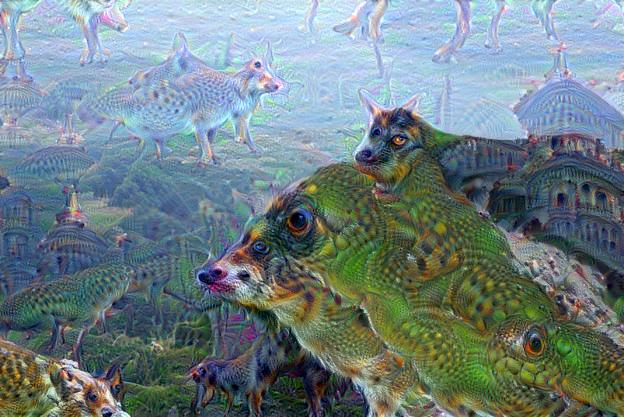

In [29]:
name = 'mixed4c'
layer_output = graph.get_tensor_by_name('import/%s:0' % name)

img0 = PIL.Image.open('mountain.jpg')
img0 = np.float32(img0)
render_deepdream(tf.square(layer_output), img0)
display(IMG('mountain_deepdream.jpg'))